# Large-scale environments for MCS/TPV cases 

In [1]:
from obspy.imaging.cm import obspy_divergent, viridis_white_r

In [2]:
import pansat 
from datetime import datetime
from pansat.products.reanalysis.era5 import ERA5Hourly, ERA5Monthly
import pandas as pd 
import matplotlib.pyplot as plt
import cartopy 
import numpy as np

# create product instance
domain = [10,60,50,130]
srfc_composite = ERA5Hourly('surface', ['vertical_integral_of_eastward_water_vapour_flux', 'vertical_integral_of_northward_water_vapour_flux', 'convective_available_potential_energy'], domain = domain)
pressure_composite = ERA5Hourly('pressure', ['geopotential', 'u', 'v'], domain = domain)


srfc_clim = ERA5Monthly('surface', ['vertical_integral_of_eastward_water_vapour_flux', 'vertical_integral_of_northward_water_vapour_flux', 'convective_available_potential_energy'], domain = domain)
pressure_clim = ERA5Monthly('pressure', ['geopotential', 'u', 'v',], domain = domain)


## Get composites 

In [3]:
# list with datetime objects 
def get_composites(times):
    '''
    Get a list of datetime.datetime objects from array with numpy.datetime times 
    (here: extracted from dataframe with MCS tracks)
    
    '''
    composites = []
    for t in times:
        t= datetime.utcfromtimestamp(t.astype(int) * 1e-9)
        year = t.year
        month = t.month
        day = t.day
        hour = t.hour
        dt= datetime(year,month,day,hour) 
        composites.append(dt)
    return composites 

In [4]:
mcstracks = pd.read_hdf('LE_east_cells_2000-2019.h5', 'table')
mcstracks['time']= pd.to_datetime(mcstracks.time)
count = 0 
for y in np.arange(2000,2019):
    ytracks = mcstracks[mcstracks.time.dt.year == y]
    for cell in np.unique(ytracks.cell.values):
        if count == 0 :
            times = ytracks[ytracks.cell==cell].time.values[0]
        count += 1 
        init = ytracks[ytracks.cell==cell].time.values[0]
        times= np.append(times, init)
        
composites = get_composites(times)

## Download corresponding data 

In [6]:
for t in composites[282::]:
    srfc_composite.download(t, t)
    pressure_composite.download(t, t)
    #srfc_clim.download(t, t)
    #pressure_clim.download(t, t)
    

Please enter your pansat user password:
········


KeyboardInterrupt: 

## Get variables from files 

In [184]:
## DEM
import xarray as xr
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xr.open_dataarray(dem)
lon_elev = elevations.lon.values
lat_elev = elevations.lat.values

######################### Composite #######################################

## wind and geopotential
file = "ERA5/reanalysis-era5-pressure-levels/reanalysis-era5-pressure-levels_2008071909_geopotential-u-v10-60-50-130.nc"
pressure = xr.open_dataset(file)
file = "ERA5/reanalysis-era5-single-levels/reanalysis-era5-single-levels_2008071909_vertical_integral_of_eastward_water_vapour_flux-vertical_integral_of_northward_water_vapour_flux-convective_available_potential_energy10-60-50-130.nc"
surface = xr.open_dataset(file)

awt_u= surface['p71.162'][0]
awt_v= surface['p72.162'][0]
cape = surface.cape[0]
lon = surface.longitude.values
lat = surface.latitude.values
lons,lats= np.meshgrid(lon,lat)
# calculate the absolute flux by adding u and v components
awt = np.abs(awt_u) + np.abs(awt_v)
# 300 hpa 
u300= pressure['u'][0][17]
v300= pressure['v'][0][17]
# 850 hpa
u850= pressure['u'][0][30]
v850= pressure['v'][0][30]
# 500 hpa 
z= pressure['z'][0][21]



#################### Climatology ###############################

## wind and geopotential
file = "ERA5/reanalysis-era5-pressure-levels-monthly-means/reanalysis-era5-pressure-levels-monthly-means_200807_geopotential-u-v-divergence10-60-50-130.nc"
pressure = xr.open_dataset(file)

file = "ERA5/reanalysis-era5-single-levels-monthly-means/reanalysis-era5-single-levels-monthly-means_200807_vertical_integral_of_eastward_water_vapour_flux-vertical_integral_of_northward_water_vapour_flux-convective_available_potential_energy10-60-50-130.nc"
surface = xr.open_dataset(file)

clim_awt_u= surface['p71.162'][0]
clim_awt_v= surface['p72.162'][0]
clim_cape = surface.cape[0]
lon = surface.longitude.values
lat = surface.latitude.values
lons,lats= np.meshgrid(lon,lat)
# calculate the absolute flux by adding u and v components
clim_awt = np.abs(clim_awt_u) + np.abs(clim_awt_v)
# 300 hpa 
clim_u300= pressure['u'][0][17]
clim_v300= pressure['v'][0][17]
# 850 hpa
clim_u850= pressure['u'][0][30]
clim_v850= pressure['v'][0][30]
# 500 hpa 
clim_z= pressure['z'][0][21]

surface.close()
pressure.close()

surface.close()
pressure.close()



## Plot 

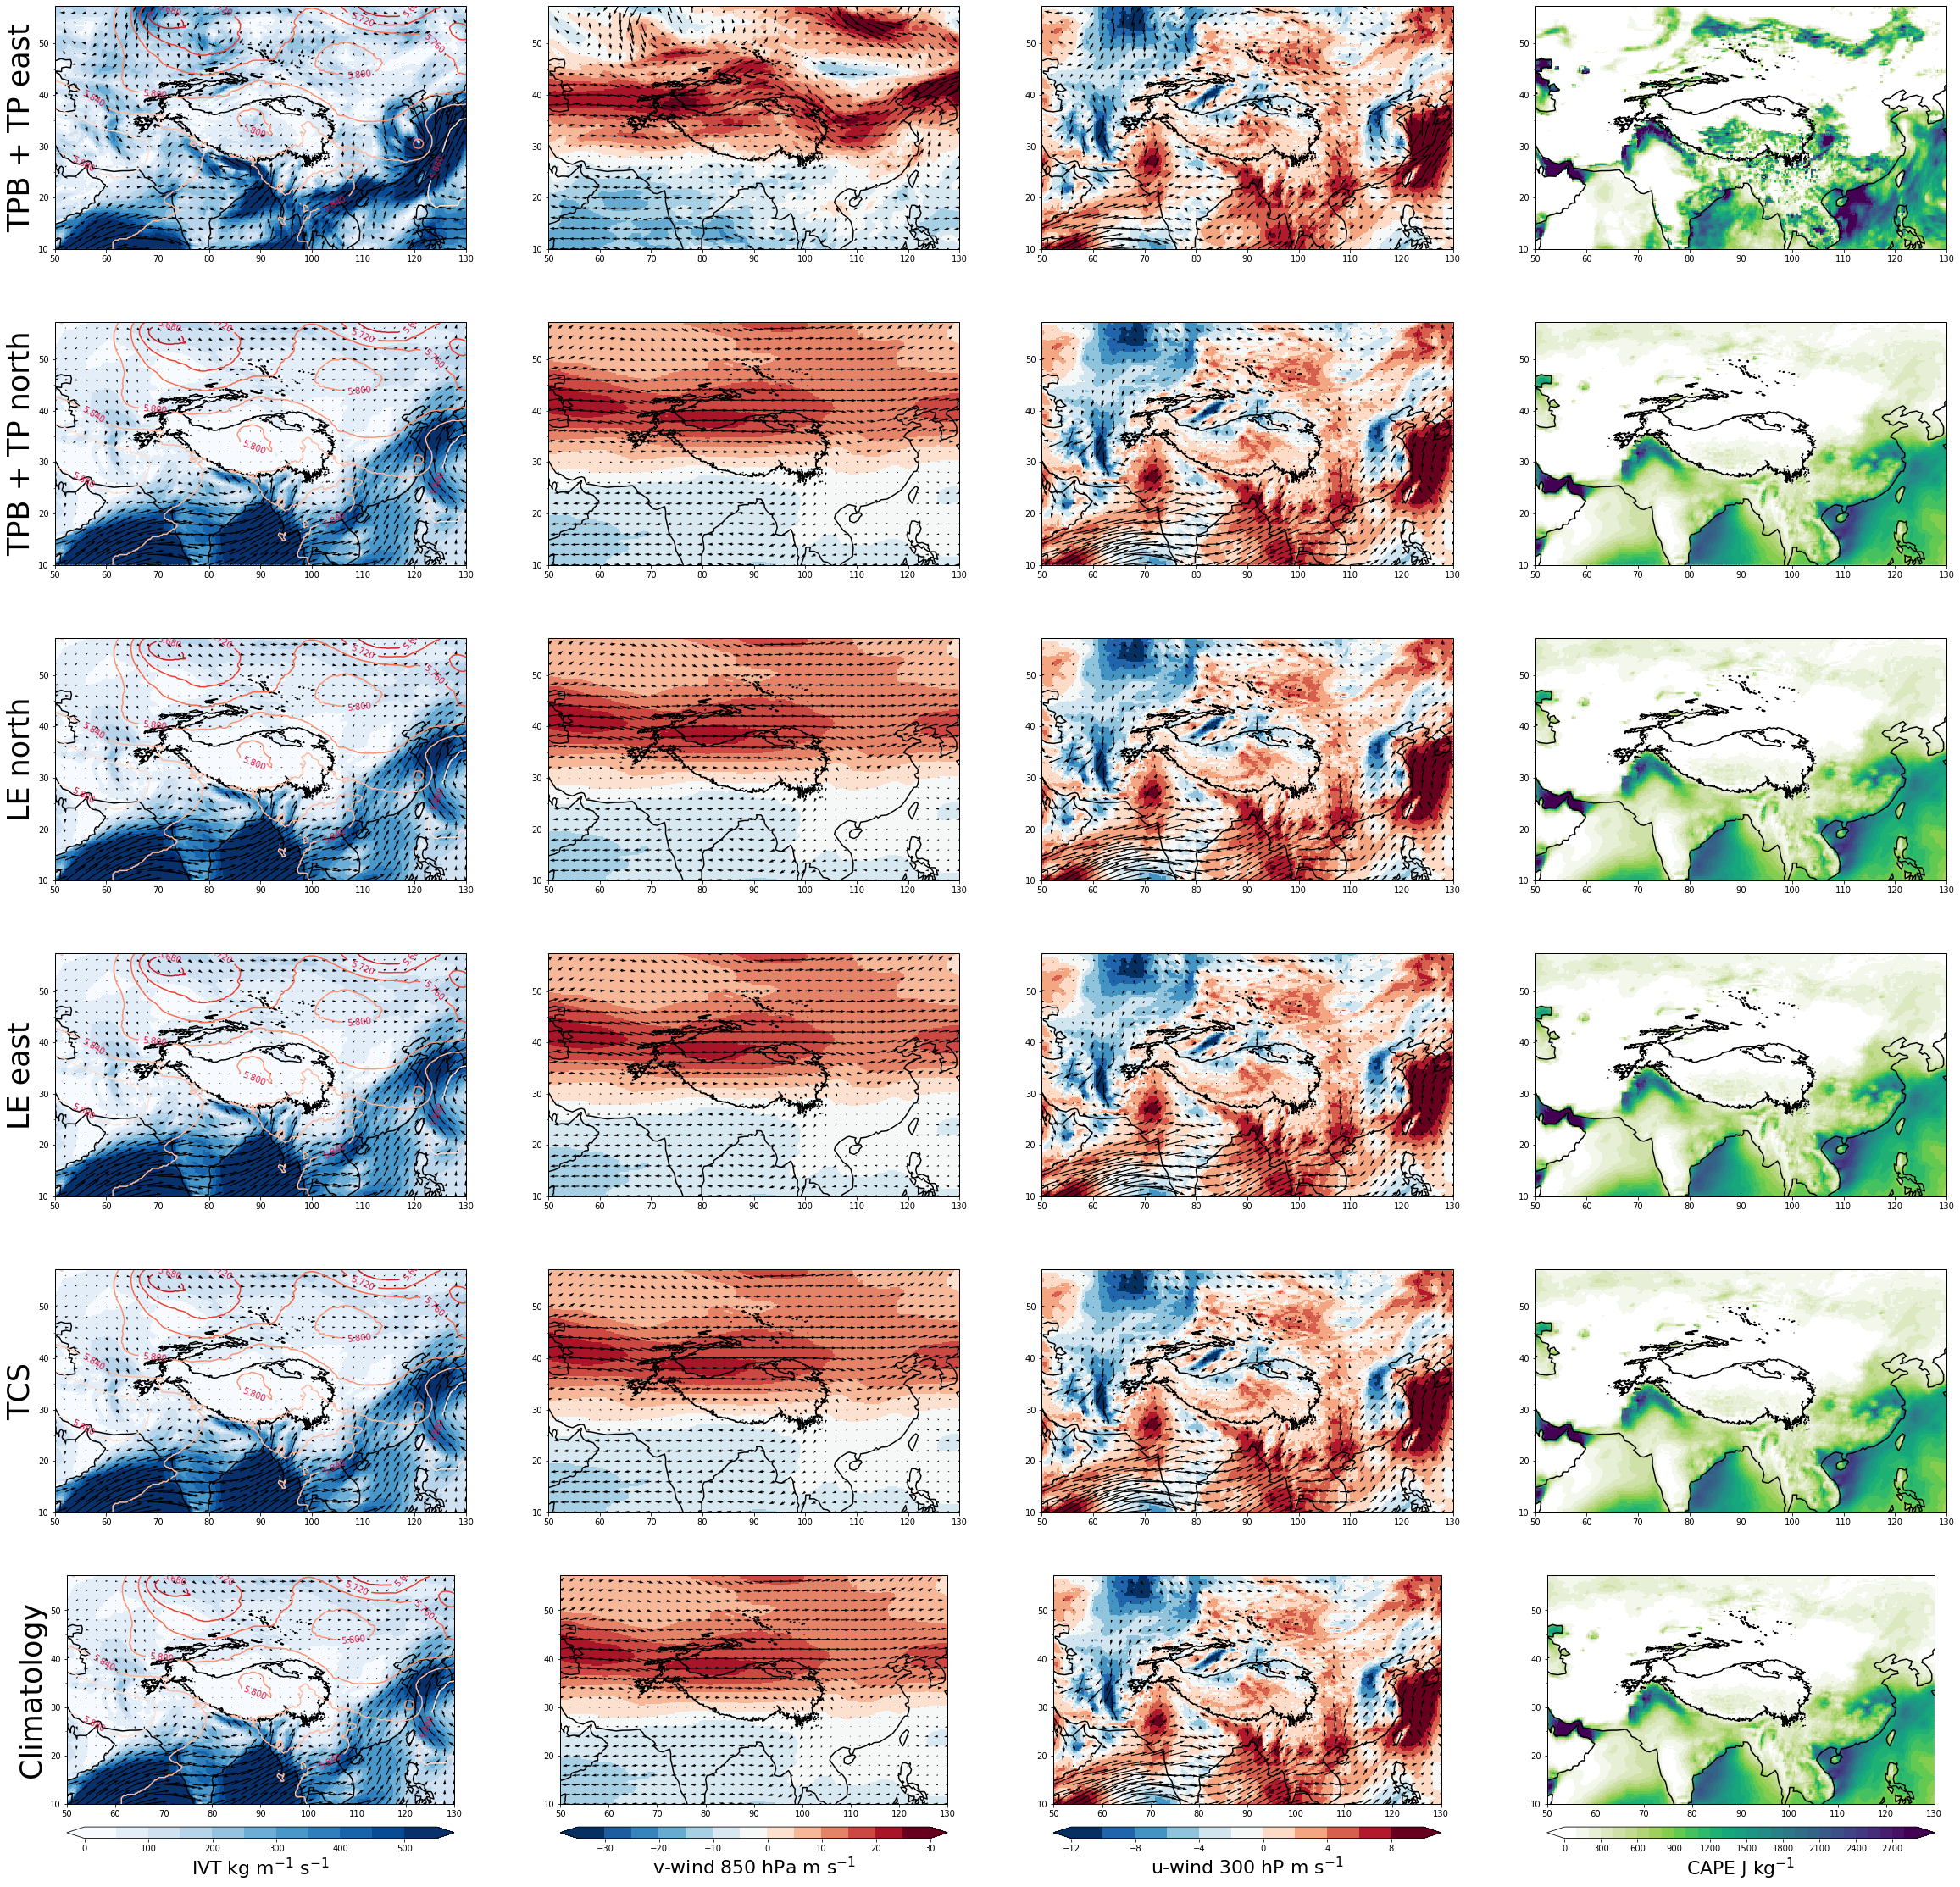

In [246]:
import quiver
import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import matplotlib.colors as colors

# axes 
xlabels=[60,70,80,90,100,110, 120]
ylabels= [25, 35 ,45]
# color bar orientation 
o = 'horizontal'
fs = 22

fig = plt.figure(figsize= (40,40))
extent = [50,130,10,50]


## AWT and geopotential

# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
cmap=plt.cm.Blues
r = np.arange(0,600,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

ax1 = plt.subplot(6, 4, 1, projection=ccrs.PlateCarree())
ax1.set_extent(extent)
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh= ax1.pcolormesh(lons, lats, awt ,norm = norm, cmap = cmap )    
ax1.quiver(x[skip],y[skip],awt_u[skip], awt_v[skip], transform= ccrs.PlateCarree()) 
m = ax1.contour(lons, lats, z.values/9.80665/1000 , cmap = 'Reds_r')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('TPB + TP east',  fontsize=35)
# Use the line contours to place contour labels.
ax1.clabel(m,  colors=['crimson'],manual=False,  inline=True)

# upper-level wind
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-35.0,35.0, 5)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax2 = plt.subplot(6, 4, 2, projection=ccrs.PlateCarree())
ax2.set_extent(extent)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax2.pcolormesh(lons, lats, u300,norm = norm, cmap = cmap )    
ax2.quiver(x[skip],y[skip],u300[skip], v300[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)



## surface wind 
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-12.0,12.0,2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax3 = plt.subplot(6, 4, 3, projection=ccrs.PlateCarree())
ax3.set_extent(extent)
ax3.coastlines(linewidth = 1.5)
ax3.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax3.pcolormesh(lons, lats, v850, norm = norm, cmap = cmap )    
ax3.quiver(x[skip],y[skip],u850[skip], v850[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)



## CAPE 
cmap=viridis_white_r
r = np.arange(0,3000,100)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax4 = plt.subplot(6, 4, 4, projection=ccrs.PlateCarree())
ax4.set_extent(extent)
ax4.coastlines(linewidth = 1.5)
ax4.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax4.pcolormesh(lons, lats, cape, norm = norm, cmap = cmap )    
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)





#########################################clim############################################################

## AWT and geopotential

# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
cmap=plt.cm.Blues
r = np.arange(0,600,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

ax1 = plt.subplot(6, 4, 5, projection=ccrs.PlateCarree())
ax1.set_extent(extent)
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh= ax1.pcolormesh(lons, lats, clim_awt ,norm = norm, cmap = cmap )    
ax1.quiver(x[skip],y[skip],clim_awt_u[skip], clim_awt_v[skip], transform= ccrs.PlateCarree()) 
m = ax1.contour(lons, lats, z.values/9.80665/1000 , cmap = 'Reds_r')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('TPB + TP north',  fontsize=35)
# Use the line contours to place contour labels.
ax1.clabel(m,  colors=['crimson'],manual=False,  inline=True)


# upper-level wind
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-35.0,35.0, 5)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax2 = plt.subplot(6, 4, 6, projection=ccrs.PlateCarree())
ax2.set_extent(extent)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax2.pcolormesh(lons, lats, clim_u300,norm = norm, cmap = cmap )    
ax2.quiver(x[skip],y[skip],clim_u300[skip], clim_v300[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)



## surface wind 
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-12.0,12.0,2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax3 = plt.subplot(6, 4, 7, projection=ccrs.PlateCarree())
ax3.set_extent(extent)
ax3.coastlines(linewidth = 1.5)
ax3.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax3.pcolormesh(lons, lats, v850, norm = norm, cmap = cmap )    
ax3.quiver(x[skip],y[skip],clim_u850[skip], clim_v850[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)


## CAPE 
cmap=viridis_white_r
r = np.arange(0,3000,100)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax4 = plt.subplot(6, 4, 8, projection=ccrs.PlateCarree())
ax4.set_extent(extent)
ax4.coastlines(linewidth = 1.5)
ax4.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
pcolormesh = ax4.pcolormesh(lons, lats, clim_cape, norm = norm, cmap = cmap )    
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)




################################################################################################

## AWT and geopotential

# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
cmap=plt.cm.Blues
r = np.arange(0,600,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

ax1 = plt.subplot(6, 4, 9, projection=ccrs.PlateCarree())
ax1.set_extent(extent)
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh= ax1.pcolormesh(lons, lats, clim_awt ,norm = norm, cmap = cmap )    
ax1.quiver(x[skip],y[skip],clim_awt_u[skip], clim_awt_v[skip], transform= ccrs.PlateCarree()) 
m = ax1.contour(lons, lats, z.values/9.80665/1000 , cmap = 'Reds_r')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('LE north',  fontsize=35)
# Use the line contours to place contour labels.
ax1.clabel(m,  colors=['crimson'],manual=False,  inline=True)


# upper-level wind
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-35.0,35.0, 5)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax2 = plt.subplot(6, 4, 10, projection=ccrs.PlateCarree())
ax2.set_extent(extent)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax2.pcolormesh(lons, lats, clim_u300,norm = norm, cmap = cmap )    
ax2.quiver(x[skip],y[skip],clim_u300[skip], clim_v300[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)



## surface wind 
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-12.0,12.0,2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax3 = plt.subplot(6, 4, 11, projection=ccrs.PlateCarree())
ax3.set_extent(extent)
ax3.coastlines(linewidth = 1.5)
ax3.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax3.pcolormesh(lons, lats, v850, norm = norm, cmap = cmap )    
ax3.quiver(x[skip],y[skip],clim_u850[skip], clim_v850[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)


## CAPE 
cmap=viridis_white_r
r = np.arange(0,3000,100)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax4 = plt.subplot(6, 4, 12, projection=ccrs.PlateCarree())
ax4.set_extent(extent)
ax4.coastlines(linewidth = 1.5)
ax4.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
pcolormesh = ax4.pcolormesh(lons, lats, clim_cape, norm = norm, cmap = cmap )    
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)


################################################################################################

## AWT and geopotential

# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
cmap=plt.cm.Blues
r = np.arange(0,600,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

ax1 = plt.subplot(6, 4, 13, projection=ccrs.PlateCarree())
ax1.set_extent(extent)
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh= ax1.pcolormesh(lons, lats, clim_awt ,norm = norm, cmap = cmap )    
ax1.quiver(x[skip],y[skip],clim_awt_u[skip], clim_awt_v[skip], transform= ccrs.PlateCarree()) 
m = ax1.contour(lons, lats, z.values/9.80665/1000 , cmap = 'Reds_r')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('LE east',  fontsize=35)
# Use the line contours to place contour labels.
ax1.clabel(m,  colors=['crimson'],manual=False,  inline=True)


# upper-level wind
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-35.0,35.0, 5)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax2 = plt.subplot(6, 4, 14, projection=ccrs.PlateCarree())
ax2.set_extent(extent)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax2.pcolormesh(lons, lats, clim_u300,norm = norm, cmap = cmap )    
ax2.quiver(x[skip],y[skip],clim_u300[skip], clim_v300[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)



## surface wind 
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-12.0,12.0,2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax3 = plt.subplot(6, 4, 15, projection=ccrs.PlateCarree())
ax3.set_extent(extent)
ax3.coastlines(linewidth = 1.5)
ax3.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax3.pcolormesh(lons, lats, v850, norm = norm, cmap = cmap )    
ax3.quiver(x[skip],y[skip],clim_u850[skip], clim_v850[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)


## CAPE 
cmap=viridis_white_r
r = np.arange(0,3000,100)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax4 = plt.subplot(6, 4, 16, projection=ccrs.PlateCarree())
ax4.set_extent(extent)
ax4.coastlines(linewidth = 1.5)
ax4.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
pcolormesh = ax4.pcolormesh(lons, lats, clim_cape, norm = norm, cmap = cmap )    
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)


##################################################################################################

## AWT and geopotential

# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
cmap=plt.cm.Blues
r = np.arange(0,600,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

ax1 = plt.subplot(6, 4, 17, projection=ccrs.PlateCarree())
ax1.set_extent(extent)
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh= ax1.pcolormesh(lons, lats, clim_awt ,norm = norm, cmap = cmap )    
ax1.quiver(x[skip],y[skip],clim_awt_u[skip], clim_awt_v[skip], transform= ccrs.PlateCarree()) 
m = ax1.contour(lons, lats, z.values/9.80665/1000 , cmap = 'Reds_r')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('TCS',  fontsize=35)
           
# Use the line contours to place contour labels.
ax1.clabel(m,  colors=['crimson'],manual=False,  inline=True)

       
# upper-level wind
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-35.0,35.0, 5)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax2 = plt.subplot(6, 4, 18, projection=ccrs.PlateCarree())
ax2.set_extent(extent)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax2.pcolormesh(lons, lats, clim_u300,norm = norm, cmap = cmap )    
ax2.quiver(x[skip],y[skip],clim_u300[skip], clim_v300[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)



## surface wind 
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-12.0,12.0,2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax3 = plt.subplot(6, 4, 19, projection=ccrs.PlateCarree())
ax3.set_extent(extent)
ax3.coastlines(linewidth = 1.5)
ax3.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh = ax3.pcolormesh(lons, lats, v850, norm = norm, cmap = cmap )    
ax3.quiver(x[skip],y[skip],clim_u850[skip], clim_v850[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
## CAPE 
cmap=viridis_white_r
r = np.arange(0,3000,100)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax4 = plt.subplot(6, 4, 20, projection=ccrs.PlateCarree())
ax4.set_extent(extent)
ax4.coastlines(linewidth = 1.5)
ax4.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
pcolormesh = ax4.pcolormesh(lons, lats, clim_cape, norm = norm, cmap = cmap )    
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)





#################################################################################################

## AWT and geopotential

# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
cmap=plt.cm.Blues
r = np.arange(0,600,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

ax1 = plt.subplot(6, 4, 21, projection=ccrs.PlateCarree())
ax1.set_extent(extent)
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh1= ax1.pcolormesh(lons, lats, clim_awt ,norm = norm, cmap = cmap )    
ax1.quiver(x[skip],y[skip],clim_awt_u[skip], clim_awt_v[skip], transform= ccrs.PlateCarree()) 
m = ax1.contour(lons, lats, z.values/9.80665/1000 , cmap = 'Reds_r')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Climatology',  fontsize=35)
# Use the line contours to place contour labels.
ax1.clabel(m,  colors=['crimson'],manual=False,  inline=True)


# upper-level wind
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-35.0,35.0, 5)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax2 = plt.subplot(6, 4, 22, projection=ccrs.PlateCarree())
ax2.set_extent(extent)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh2 = ax2.pcolormesh(lons, lats, clim_u300,norm = norm, cmap = cmap )    
ax2.quiver(x[skip],y[skip],clim_u300[skip], clim_v300[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)



## surface wind 
cmap=plt.cm.PuOr
cmap=obspy_divergent
r = np.arange(-12.0,12.0,2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax3 = plt.subplot(6, 4, 23, projection=ccrs.PlateCarree())
ax3.set_extent(extent)
ax3.coastlines(linewidth = 1.5)
ax3.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y  = lons,lats
skip  =(slice(None,None,8),slice(None,None,8))
pcolormesh3 = ax3.pcolormesh(lons, lats, v850, norm = norm, cmap = cmap )    
ax3.quiver(x[skip],y[skip],clim_u850[skip], clim_v850[skip], transform= ccrs.PlateCarree()) 
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)


## CAPE 
cmap=viridis_white_r
r = np.arange(0,3000,100)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax4 = plt.subplot(6, 4, 24, projection=ccrs.PlateCarree())
ax4.set_extent(extent)
ax4.coastlines(linewidth = 1.5)
ax4.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
pcolormesh4 = ax4.pcolormesh(lons, lats, clim_cape, norm = norm, cmap = cmap )    
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)


#colorbars

cbar = make_colorbar(ax1, pcolormesh1, orientation=o)
cbar.set_label('IVT kg m$^{-1}$ s$^{-1}$', fontsize = fs)
cbar =make_colorbar(ax2, pcolormesh2, orientation=o)
cbar.set_label('v-wind 850 hPa m s$^{-1}$', fontsize = fs)
cbar =make_colorbar(ax3, pcolormesh3, orientation=o)
cbar.set_label('u-wind 300 hP m s$^{-1}$', fontsize = fs)
cbar = make_colorbar(ax4, pcolormesh4, orientation=o)
cbar.set_label('CAPE J kg$^{-1}$', fontsize = fs)


plt.savefig('plots/synoptic_environments.png')
plt.show()

In [245]:
def make_colorbar(ax, mappable, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl

    divider = make_axes_locatable(ax)
    orientation = kwargs.pop('orientation', 'vertical')
    if orientation == 'vertical':
        loc = 'right'
    elif orientation == 'horizontal':
        loc = 'bottom'
        
    cax = divider.append_axes(loc, '5%', pad='10%', axes_class=mpl.pyplot.Axes)
    cbar = ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation, extend = 'both')
    return cbar